<a href="https://colab.research.google.com/github/anna030608/DS/blob/master/260128/Marketing_A_B_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 문제 정의 & 가설 설정

### 문제 정의
- 광고(ad)를 노출한 사용자 그룹이 공익광고(psa)를 노출한 사용자 그룹보다 전활율(conversion rate)이 더 높은가?
  - 마케팅/제품팀의 목적은 보통 "클릭/전환 증가"임.
  - 이 데이터셋에서는 전환 여부(converted)가 있으므로, 광고가 실제로 전환을 높였는지 통계적으로 검증할 수 있음.
---
### 실험 설정 (A/B 정의)
- Control (대조군): test_group == "psa"

- Treatment (실험군): test_group == "ad"

  - 일반적으로 Control은 "기존 방식/대체안"이고, Treatment는 "변경안(광고)"이다. 여기서는 광고가 실제 마케팅에 가까운 개입이므로 ad를 Treatment로 둠.
---
### 핵심 지표 정의
- 1차(Primary) 지표: 전환율(Conversion Rate)

데이터 컬럼: converted (0/1)

전환율 정의:
p = 전환한 사용자 수 / 전체 사용자 수

이 과제에서 가장 “정석”은 전환율 비교(두 비율 비교) 입니다.

---
### 가설 설정 (Hypothesis)
- 귀무가설 H0 : 광고(ad) 그룹과 공익광고(psa) 그룹의 전환율은 같다.

- 대립가설 H1 : 광고(ad) 그룹의 전환율이 더 높다.

- 왜 단측(one-sided) 검정을 쓰나?
우리가 알고 싶은 건 “광고가 개선시키는가?”이지, “차이가 있는가?”가 아니라는 점에서 방향이 명확하므로 단측검정( larger )이 자연스럽습니다.

---
### 유의수준 a 설정
유의수준: α=0.05 (보편적 기준)

의사결정:

p-value < 0.05 → H0기각 → “광고가 전환율을 유의미하게 높였다”

p-value ≥ 0.05 → H0기각 못함 → “광고 효과가 있다고 말하기 어렵다”

In [3]:
### Step 1. Problem & Hypothesis Setup

# 실험 설정
CONTROL_GROUP = "psa"
TREATMENT_GROUP = "ad"

# 핵심 지표(Primary Metric)
PRIMARY_METRIC = "converted"  # 0/1 conversion

# 유의수준
ALPHA = 0.05

# 가설(문서화 용도)
H0 = "p_ad == p_psa  (no difference in conversion rate)"
H1 = "p_ad  > p_psa  (ad increases conversion rate)"

problem_statement = """
광고(ad)를 노출한 사용자 그룹이 공익광고(psa)를 노출한 사용자 그룹보다
전환율(conversion rate)을 유의미하게 증가시키는지 검정한다.
"""

print(problem_statement)
print("CONTROL_GROUP:", CONTROL_GROUP)
print("TREATMENT_GROUP:", TREATMENT_GROUP)
print("PRIMARY_METRIC:", PRIMARY_METRIC)
print("ALPHA:", ALPHA)
print("H0:", H0)
print("H1:", H1)


광고(ad)를 노출한 사용자 그룹이 공익광고(psa)를 노출한 사용자 그룹보다
전환율(conversion rate)을 유의미하게 증가시키는지 검정한다.

CONTROL_GROUP: psa
TREATMENT_GROUP: ad
PRIMARY_METRIC: converted
ALPHA: 0.05
H0: p_ad == p_psa  (no difference in conversion rate)
H1: p_ad  > p_psa  (ad increases conversion rate)


# 2. 데이터 로드
- Unnamed: 0 -> 단순 인덱스 컬럼
- user id -> 사용자 고유 ID
- test group -> 실험군 배정 정보 (ad / psa)
- converted -> 사용자가 전환했는지 여부
- total ads -> 해당 사용자가 본 광고의 총 횟수
  - 광고 효과 vs 광고 노출량 효과를 구분해야 함.
  - 만약 ad 그룹이 광고를 훨씬 더 많이 봤다면, 전환율 상승은 '광고 품질'이 아니라 '노출량 증가'때문일 수 있음.

- most ads day -> 사용자가 광고를 가장 많이 본 요일
- most ads hour -> 광고를 가장 많이 본 시간대 (0~23)

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("faviovaz/marketing-ab-testing")

print("Path to dataset files:", path)

100%|██████████| 5.23M/5.23M [00:01<00:00, 5.47MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/faviovaz/marketing-ab-testing/versions/1


In [5]:
import os

## 폴더 속 파일 목록 확인.
files = os.listdir(path)
print("Files:", files)

Files: ['marketing_AB.csv']


In [6]:
import pandas as pd

## 데이터 로드.
csv_path = os.path.join(path, "marketing_AB.csv")
df = pd.read_csv(csv_path)

print(df.shape)

(588101, 7)


In [8]:
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


In [13]:
df.isna().sum()

,0
Unnamed: 0,0
user id,0
test group,0
converted,0
total ads,0
most ads day,0
most ads hour,0


In [23]:
print("len(df): ", len(df))
print("user id 개수: ", df['user id'].nunique())
print("중복 사용자 있는지 여부: ", df['user id'].nunique() != len(df))

len(df):  588101
user id 개수:  588101
중복 사용자 있는지 여부:  False


In [10]:
### 그룹 분포 확인하기 (A/B)
df['test group'].value_counts()

,count
test group,
ad,564577
psa,23524


- 각 집단 내 표본수가 충분하기에 A/B Test 진행에는 문제가 없지만, 해석을 조심해야 하는 상태이다.
- 효과 크기도 반드시 같이 봐야 한다.
  - ad 쪽 표본이 압도적으로 크면, 아주 작은 차이도 p-value는 작아질 수 있기 때문에, p-value만 보고 결론은 내리지 말고 effect size도 반드시 같이 봐야 할 것 같다.

In [24]:
df["converted"].value_counts(dropna=False)
df["converted"].value_counts(normalize=True, dropna=False)

,proportion
converted,
False,0.974761
True,0.025239


converted 분포
- 전체 전환율 = 약 2.5%
- 마케팅/광고 데이터에서 매우 정상적인 수준.

# 3. 실험 설계 검증
목적 : 광고 효과를 보기 전에, 두 그룹이 "공정하게 비교 가능한 상태인지"를 검증.
- 즉, 전환율 차이가 광고 자체의 효과인지, 아니면 광고를 더 많이/특정 시간에 본 결과인지를 구분하기 위함.
  - A/B Test의 핵심 전제는 ❝A와 B의 차이는 오직 ‘처치(treatment)’ 때문이어야 한다❞.

- 검증할 항목
  - total ads 분포 : 광고효과 vs 노출량 효과
  - 요일 분포 : 요일별 전환율 차이
  - 시간대 분포 : 사용자 행동 패턴 차이

In [25]:
df.columns

Index(['Unnamed: 0', 'user id', 'test group', 'converted', 'total ads',
       'most ads day', 'most ads hour'],
      dtype='object')

In [26]:
### 컬럼명 공백 정리
df = df.rename(columns={
    "user id": "user_id",
    "test group": "test_group",
    "total ads": "total_ads",
    "most ads day": "most_ads_day",
    "most ads hour": "most_ads_hour"
})


In [27]:
df.columns

Index(['Unnamed: 0', 'user_id', 'test_group', 'converted', 'total_ads',
       'most_ads_day', 'most_ads_hour'],
      dtype='object')

In [28]:
### total_ads 분포 비교
### 그룹별 평균 , 중앙값 비교

df.groupby('test_group')['total_ads'].agg(['mean','median','std','min','max'])

,mean,median,std,min,max
test_group,,,,,
ad,24.823365,13.0,43.750456,1,2065
psa,24.761138,12.0,42.860720,1,907


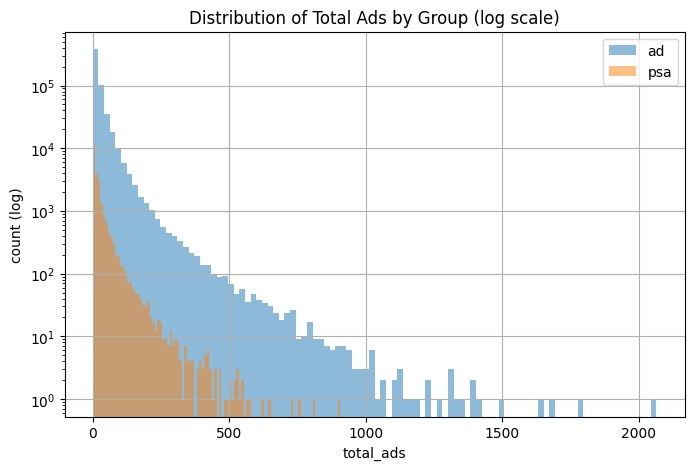

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
for group in ["ad", "psa"]:
    df[df["test_group"] == group]["total_ads"].hist(
        bins=100, alpha=0.5, label=group, log=True
    )

plt.legend()
plt.title("Distribution of Total Ads by Group (log scale)")
plt.xlabel("total_ads")
plt.ylabel("count (log)")
plt.show()

광고 노출량(total_ads)은 두 그룹 간에 실질적인 차이가 거의 없다.

In [46]:
# 요일 분포 비교


# 그룹 - 요일 비율
day_dist = (
    df.groupby(["test_group", "most_ads_day"])
      .size()
      .reset_index(name="count")
)

day_dist["ratio"] = (
    day_dist["count"] /
    day_dist.groupby("test_group")["count"].transform("sum")
)

day_table = day_dist.pivot(
    index="most_ads_day",
    columns="test_group",
    values="ratio"
)

day_table

test_group,ad,psa
most_ads_day,,
Friday,0.157295,0.161665
Monday,0.148024,0.148869
Saturday,0.139577,0.121493
Sunday,0.145830,0.130037
Thursday,0.140064,0.166001
Tuesday,0.132085,0.123576
Wednesday,0.137126,0.148359


요일 분포는 전반적으로 유사

요일 효과가 실험 결과를 왜곡할 정도는 아님

In [47]:
## 시간대 분포 비교
hour_dist = (
    df.groupby(["test_group", "most_ads_hour"])
      .size()
      .reset_index(name="count")
)

hour_dist["ratio"] = (
    hour_dist["count"] /
    hour_dist.groupby("test_group")["count"].transform("sum")
)

hour_table = hour_dist.pivot(
    index="most_ads_hour",
    columns="test_group",
    values="ratio"
)

hour_table

test_group,ad,psa
most_ads_hour,,
0,0.009404,0.009650
1,0.008174,0.007949
2,0.009125,0.007694
3,0.004588,0.003783
4,0.001229,0.001190
5,0.001314,0.000978
6,0.003516,0.003528
7,0.010925,0.010075
8,0.030054,0.028014


사용자 행동 패턴이 거의 동일

시간대 역시 교란 요인으로 보기 어려움

=> total_ads, 요일, 시간대 분포 모두에서
광고(ad) 그룹과 공익광고(psa) 그룹은 충분히 유사한 분포를 보인다.

=> 따라서 본 데이터는 Randomization이 비교적 잘 유지된 A/B 테스트 데이터로 판단되며,
단순 전환율 비교 및 비율 검정을 수행하는 것이 타당하다.

# 4. A/B Test 본검정 (두 비율 z-test)
광고(ad)가 공익광고(psa) 대비 전환율을 유의미하게 증가시켰는가?

In [48]:
## 통계량 계산

# 그룹별 전환율
# 그룹별 전환 수 / 전체 수
group_stats = df.groupby("test_group")["converted"].agg(
    n="count",
    conversions="sum",
    conversion_rate="mean"
)

group_stats

,n,conversions,conversion_rate
test_group,,,
ad,564577,14423,0.025547
psa,23524,420,0.017854


그룹별 전환율
- ad 그룹이 psa대비 전환율이 더 높음

In [49]:
# z-test
from statsmodels.stats.proportion import proportions_ztest

success = group_stats.loc[["ad", "psa"], "conversions"].values
nobs = group_stats.loc[["ad", "psa"], "n"].values

z_stat, p_value = proportions_ztest(
    count=success,
    nobs=nobs,
    alternative="larger"  # ad > psa
)

z_stat, p_value

(np.float64(7.3700781265454145), np.float64(8.526403580779863e-14))

통계 검정 결과 (Two-proportion Z-test)
- z-statistic = 7.37
- p-value = 8.53 × 10⁻¹⁴
- p-value < 0.05

-> 귀무가설 H0 기각

-> 광고(ad)가 전환율을 통계적으로 유의미하게 증가시켰다.

(표본 수가 매우 크기 때문에 z가 크게 나오고 p-value가 극단적으로 작게 나온 것은 자연스러운 결과..)

In [51]:
### Effect Size 계산
# 절대 차이 (percentage point)
delta = (
    group_stats.loc["ad", "conversion_rate"]
    - group_stats.loc["psa", "conversion_rate"]
)

delta

np.float64(0.007692453192201517)

- 0.7%p 이상 상승
- 마케팅 맥락에서는 작은 효과가 아님.

In [52]:
# 상대 상승률
relative_lift = (
    group_stats.loc["ad", "conversion_rate"]
    / group_stats.loc["psa", "conversion_rate"]
    - 1
)

relative_lift

np.float64(0.4308506402222583)

- 광고(ad)는 공익광고(psa) 대비 전환 가능성을 약 43% 증가.
- 꽤나 강한 효과라고 볼 수 있음.

In [53]:
## 신뢰 구간 계산
import numpy as np

p1, p2 = group_stats.loc["ad", "conversion_rate"], group_stats.loc["psa", "conversion_rate"]
n1, n2 = group_stats.loc["ad", "n"], group_stats.loc["psa", "n"]

se = np.sqrt(
    p1*(1-p1)/n1 + p2*(1-p2)/n2
)

ci_low = delta - 1.96 * se
ci_high = delta + 1.96 * se

ci_low, ci_high

(np.float64(0.00595090043017032), np.float64(0.009434005954232714))

(0.00595 , 0.00943)
- 전환율 증가폭은 최소 +0.60%p ~ 최대 +0.94%p
- 이런 효과가 우연이 아니고, 데이터 샘플링 변동을 고려해도 항상 '광고가 더 좋다'는 결론이 유지됨.
- 통계적 안정성이 매우 높다고 볼 수 있다.
---

## 1. 프로젝트 목적 요약

본 프로젝트의 목적은 마케팅 광고(ad)가 공익광고(psa)에 비해 사용자 전환율을 유의미하게 증가시키는지를 A/B 테스트를 통해 검증하는 것이다.
이를 위해 Kaggle의 Marketing A/B Testing 데이터셋을 활용하여, 실험 설계 검증부터 통계적 가설 검정까지 단계적으로 분석을 수행하였다.


## 2. 분석 과정 요약 (Step-by-Step)
(1) 문제 정의 및 가설 설정

- 귀무가설(H₀): 광고(ad)와 공익광고(psa)의 전환율은 같다
- 대립가설(H₁): 광고(ad)의 전환율이 공익광고(psa)보다 높다

(2) 데이터 검증 및 실험 설계 확인

- 전체 사용자 수: 약 58만 명
- ad / psa 그룹 간 표본 수는 불균형하였으나,
psa 그룹 또한 충분한 표본 크기를 가지고 있어 통계적 검정은 가능함

- 광고 노출 횟수(total_ads), 요일, 시간대 분포 비교 결과

→ 두 그룹 간 분포는 전반적으로 유사

→ Randomization이 비교적 잘 유지된 실험 환경으로 판단

(3) A/B 테스트 본검정

검정 방법: 두 비율 z-test (one-sided)

전환율
- ad: 2.55%
- psa: 1.79%

통계 검정 결과
- z-statistic = 7.37
- p-value ≈ 8.53 × 10⁻¹⁴

→ 유의수준 0.05 하에서 귀무가설 기각

3️⃣ 핵심 결과 요약 (숫자로 한 번에)
- 절대 전환율 증가	+0.77%p
- 상대 상승률	+43.1%
- 95% 신뢰구간	[+0.60%p, +0.94%p]
- 통계적 유의성	매우 높음 (p ≪ 0.05)

4️⃣ 핵심 인사이트 (중요)

인사이트 1: 광고는 “통계적으로 유의미”하다
- p-value가 매우 작고 신뢰구간이 0을 포함하지 않음
- 전환율 차이는 우연이 아니라 광고 효과에 의한 결과로 해석 가능

인사이트 2: 효과 크기 또한 “실무적으로 의미 있다”
- 전환율이 약 2% 수준인 환경에서
+0.77%p 증가는 상당한 개선
- 상대적으로 약 43%의 전환율 상승 효과

  → 마케팅 실무에서는 충분히 실행을 고려할 만한 수준

인사이트 3: 실험 설계가 결과 신뢰도를 뒷받침한다

- 광고 노출 횟수, 요일, 시간대 등 주요 교란 변수들이
두 그룹 간 유사한 분포를 보임
- 따라서 결과는 광고 자체의 효과로 해석할 수 있는 타당한 근거를 가짐

## 5. 한계점 및 주의사항

ad / psa 그룹의 표본 수가 균형적이지 않음
→ 효과 크기 해석 시 과대평가 가능성에 주의 필요

비용 정보(광고 단가, ROI)가 없어
비즈니스 의사결정까지는 추가 데이터가 필요

장기 효과(피로도, 반복 노출 효과)는 본 분석에서 고려되지 않음

---
## 최종 결론
본 A/B 테스트 분석 결과, 광고(ad)는 공익광고(psa)에 비해 사용자 전환율을 통계적·실무적으로 모두 유의미하게 증가시키는 효과가 있음을 확인하였다.